In [1]:
import pandas as pd                                            # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np                                             # linear algebra
import matplotlib.pyplot as plt                                # plotting
import seaborn as sns                                          # advance plotting
#from wordcloud import WordCloud # to see the words as image
import torch                                                   # PyTorch for building Networks
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.data.utils import get_tokenizer                 # TorchText has Text processing Function
from torchtext import vocab
from sklearn.model_selection import train_test_split           # split the data into training and testing
from sklearn.metrics import accuracy_score                     # accuracy metric
from sklearn.preprocessing import LabelEncoder
from nltk import word_tokenize                                 # Text processing Library
from nltk.tokenize import WordPunctTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import random                                                  # to perform randomisation of tasks
from tqdm.notebook import tqdm                                 # for a continuous progress bar style
import time                                                    # time module 
import os                                                      # import operating system
import re

In [2]:
IN_PATH = '/kaggle/input/'
DATA_PATH = IN_PATH+'nlp-txt-classification/'
OUT_PATH = '/kaggle/working/' # path for output directory 
GLOVE_TEXT_PATH = 'glove6b100dtxt/glove.6B.100d.txt' # glove directory
EPOCH = 5 # number of epochs to run for model

SEED = 42 # reproducible results: Same results in every run
np.random.seed(SEED) 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # cuda algorithms
os.environ['PYTHONHASHSEED'] = str(SEED)

NUM_CLASSES = 5
MAX_VOCAB_SIZE = 250000
BATCH_SIZE = 64
debug = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use 'cuda' if available else 'cpu'

In [3]:
train_df = pd.read_csv(DATA_PATH+'train.csv')
train_df.head()

,Unnamed: 0,Text,Sentiment
0,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,1,advice Talk to your neighbours family to excha...,Positive
2,2,Coronavirus Australia: Woolworths to give elde...,Positive
3,3,My food stock is not the only one which is emp...,Positive
4,4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
train_df.Sentiment.value_counts(normalize=True)

Positive              0.277536
Negative              0.240967
Neutral               0.187365
Extremely Positive    0.160952
Extremely Negative    0.133179
Name: Sentiment, dtype: float64

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41159 entries, 0 to 41158
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  41158 non-null  object
 1   Text        41158 non-null  object
 2   Sentiment   41155 non-null  object
dtypes: object(3)
memory usage: 964.8+ KB


In [6]:
train_df.dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41155 entries, 0 to 41158
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  41155 non-null  object
 1   Text        41155 non-null  object
 2   Sentiment   41155 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [7]:
for i, text in enumerate(train_df.Text[:20]):
  print(i+1, ":",  text)
  print()

1 : @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8

2 : advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order

3 : Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P






#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j





#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n

6 : As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU

7 : Cashier at grocery store wa

In [8]:
test_df = pd.read_csv(DATA_PATH+'test.csv')
test_df.head()

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...


# Data cleaning

In [9]:
def remove_special_characters(text, remove_digits=True):
    text = re.sub('http://\S+|https://\S+|www.\S+', '', text)
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text.strip()

In [10]:
sentence = '@eyeonthearctic 16MAR20 Russia consumer surveillance watchdog reported case in high Arctic where a man who traveled to Iran has COVID-19 and 101 are "observed" https://t.co/4WnrrK9oKC https://t.co/ld05k5Eyns'
remove_special_characters(sentence)

'eyeonthearctic MAR Russia consumer surveillance watchdog reported case in high Arctic where a man who traveled to Iran has COVID and  are observed'

In [11]:
train_df.Text = train_df.Text.apply(remove_special_characters)
train_df.head()

,Unnamed: 0,Text,Sentiment
0,0,MeNyrbie Phil_Gahan Chrisitv and and,Neutral
1,1,advice Talk to your neighbours family to excha...,Positive
2,2,Coronavirus Australia Woolworths to give elder...,Positive
3,3,My food stock is not the only one which is emp...,Positive
4,4,Me ready to go at supermarket during the COVID...,Extremely Negative


In [12]:
test_df.Text = test_df.Text.apply(remove_special_characters)
test_df.head()

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING New Yorkers encounter empty supermark...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldnt find hand sanitizer at Fred Mey...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Panic buying hits NewYork City as anxious shop...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,toiletpaper dunnypaper coronavirus coronavirus...


<AxesSubplot:>

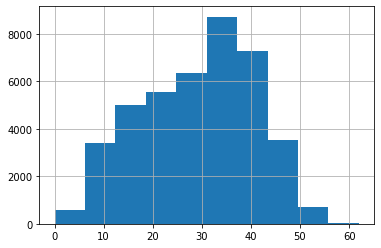

In [13]:
train_df["number_of_words"] = train_df.Text.apply(lambda txt: len(txt.split()))
train_df["number_of_words"].hist()

In [14]:
train_df.query("number_of_words<=1")

,Unnamed: 0,Text,Sentiment,number_of_words
583,583,__,Neutral,1
2385,2385,,Neutral,0
5214,5214,,Neutral,0
8803,8803,coronavirus,Neutral,1
8808,8808,ynetalerts,Neutral,1
8841,8841,,Neutral,0
13843,13843,,Neutral,0
14840,14840,__,Neutral,1
16920,16920,,Neutral,0
18437,18437,,Neutral,0


# Split data into Test and Train

In [15]:
sentimental_data = train_df[['Text', 'Sentiment']]
sentimental_data.columns=['Sentence', 'Label']
sentimental_data.head()

,Sentence,Label
0,MeNyrbie Phil_Gahan Chrisitv and and,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia Woolworths to give elder...,Positive
3,My food stock is not the only one which is emp...,Positive
4,Me ready to go at supermarket during the COVID...,Extremely Negative


In [16]:
X_train, X_val, y_train, y_val = train_test_split(train_df.Text, train_df.Sentiment,
                                                  stratify=train_df.Sentiment, 
                                                  test_size=0.2,
                                                  random_state=SEED)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((32924,), (8231,), (32924,), (8231,))

In [17]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(list(X_train) + list(X_val) + list(test_df.Text))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_df.Text)

<AxesSubplot:ylabel='Frequency'>

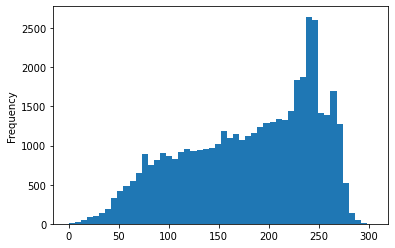

In [18]:
All_sentenses = pd.concat([train_df.Text, test_df.Text], axis=0)
lens = All_sentenses.apply(lambda s: len(s))
lens.plot.hist(bins=50)

In [19]:
lens.quantile(0.95), max(lens)

(267.0, 304)

In [20]:
MAX_TEXT_LEN = 280

In [21]:
X_train = pad_sequences(X_train, maxlen=MAX_TEXT_LEN)
X_val = pad_sequences(X_val, maxlen=MAX_TEXT_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_TEXT_LEN)

In [22]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_train

array([0, 1, 0, ..., 1, 2, 1])

In [23]:
train_df.Sentiment.head()

0               Neutral
1              Positive
2              Positive
3              Positive
4    Extremely Negative
Name: Sentiment, dtype: object

In [24]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2022-05-03 04:12:15--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2022-05-03 04:12:15--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2022-05-03 04:12:15--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [25]:
!unzip glove.840B.300d.zip
!ls -lat

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     
total 7639892
---------- 1 root root     225251 May  3 04:20 __notebook__.ipynb
drwxr-xr-x 2 root root       4096 May  3 04:19 .
drwxr-xr-x 6 root root       4096 May  3 04:11 ..
-rw-r--r-- 1 root root 2176768927 Oct 24  2015 glove.840B.300d.zip
-rw-rw-r-- 1 root root 5646236541 Oct 24  2015 glove.840B.300d.txt


In [26]:
def load_glove(word_index):
    EMBEDDING_FILE = 'glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(MAX_VOCAB_SIZE, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= MAX_VOCAB_SIZE: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [27]:
if debug:
    embedding_matrix = np.random.randn(MAX_VOCAB_SIZE,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
max_features, embed_size = embedding_matrix.shape

# BiLSTM

In [29]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [30]:
n_epochs = 3 
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [31]:
model.to(device)

BiLSTM(
  (embedding): Embedding(64607, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=5, bias=True)
)

In [32]:
# Load train and test in CUDA Memory
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.long).to(device)

In [33]:
# Create Torch datasets
train = torch.utils.data.TensorDataset(X_train, y_train)
valid = torch.utils.data.TensorDataset(X_val, y_val)

In [34]:
# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.to(device)
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(X_val),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * BATCH_SIZE : (i+1) * BATCH_SIZE] = F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(torch.eq(torch.tensor(val_preds.argmax(axis=1)), y_val)) / len(y_val)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/3 	 loss=82.5679 	 val_loss=67.8535  	 val_acc=0.5489  	 time=229.78s
Epoch 2/3 	 loss=64.2356 	 val_loss=60.4816  	 val_acc=0.6094  	 time=228.40s
Epoch 3/3 	 loss=55.7946 	 val_loss=55.1380  	 val_acc=0.6512  	 time=226.30s


In [36]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

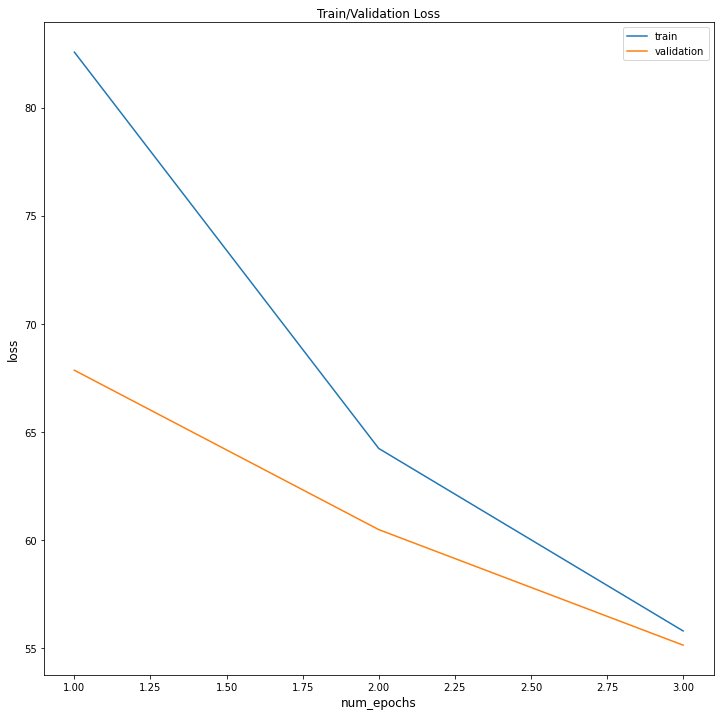

In [37]:
plot_graph(n_epochs)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

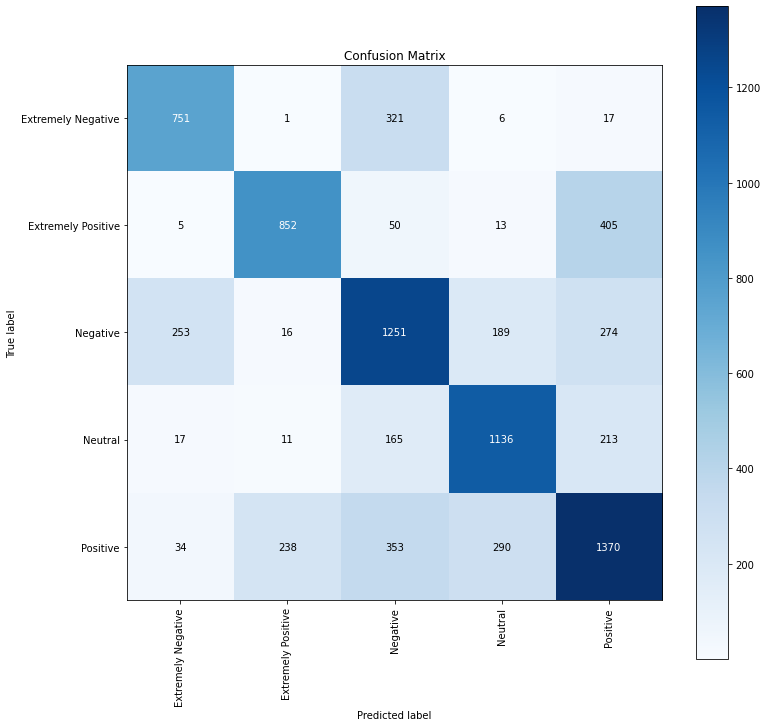

In [38]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in y_val]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

# Submission

In [39]:
sample_submission = pd.read_csv(DATA_PATH+'sample_submission.csv')
sample_submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Neutral
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Neutral
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Neutral
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Neutral
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


In [40]:
sample_submission.Sentiment.value_counts()

Neutral    3798
Name: Sentiment, dtype: int64

In [41]:
pred = model(X_test).detach()

In [42]:
pred = F.softmax(pred).cpu().numpy()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [43]:
pred = pred.argmax(axis=1)

In [44]:
pred = le.classes_[pred]

In [45]:
sample_submission.Sentiment = pred

In [46]:
sample_submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Extremely Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


In [47]:
sample_submission.to_csv('submission.csv', index=False)